In [1]:
import os
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils.dataloader import DataLoader
from utils.vis import MatplotlibVisualizer
from utils.transforms import HairRemoval, Composer, CentricCropping
from utils.utils import export_experiment
from descriptors.shape import HOGDescriptor
from utils.segmentation import ThresholdingSegmentation
from descriptors.stats import IntensityStatsGridDescriptor
from descriptors.texture import LBPDescriptor, GLCMDescriptor, GaborFilterDescriptor, ColorMultiScaleLBPDescriptor
from descriptors.color import ColorDescriptor, ColorLayoutDescriptor, ColorCooccurrenceMatrixDescriptor

In [2]:
## Classes
CLASSES = ['nevus', 'others']

## Work folfer
work_folder = os.getcwd()
data_folder = os.path.join(work_folder, '..', 'Data/Challenge1')

## Visualizer
matplotlib_visualizer = MatplotlibVisualizer()
exp_name = 'binary_classification'

In [3]:

transforms_composer = Composer([
                                # HairRemoval(),
                                CentricCropping(grid_size=(3,3))
                                ])

## Featrure Extraction

### Descriptors

In [127]:
## Define parameters
params = {
    'color_layout': {
        'grid_x': 1,
        'grid_y': 1,
    },
    'intensity_stats': {
        'grid_x': 1,
        'grid_y': 1,
    },
    'color': {
        'bins': (8, 12, 3),
        # 'grid_x': 1,
        # 'grid_y': 1,
    },
    'glcm': {
        'distances': [1],
        'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],
        'levels': 8,
        'grid_x': 1,
        'grid_y': 1,
    },
    'lbp': {
        'radius': 4,
        'n_points': 16,
        'grid_x': 1,
        'grid_y': 1,
    },
    'color_cooccurrence_matrix': {
        'distances': [1],
        'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],
        'levels': 8,
        'grid_x': 1,
        'grid_y': 1,
    },
}

In [144]:
modes = ['train', 'val']

## Descriptors
color_layout_descriptor = ColorLayoutDescriptor(**params['color_layout'])
intensity_stats_grid_descriptor = IntensityStatsGridDescriptor(**params['intensity_stats'])
color_descriptor = ColorDescriptor(**params['color'])
glcm_descriptor = GLCMDescriptor(**params['glcm'])
lbp_descriptor = LBPDescriptor(**params['lbp'])
color_cooccurrence_matrix_descriptor = ColorCooccurrenceMatrixDescriptor(**params['color_cooccurrence_matrix'])
color_multiscale_lbp_descriptor = ColorMultiScaleLBPDescriptor(radius=3, n_points=16, scales=[1, 2])
# gabor_filter_descriptor = GaborFilterDescriptor(frequencies=[0.1, 0.2, 0.3], orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4])

features_dict = {}

for mode in modes:

    ## Data loader
    ### Limit the number of samples to 200 for training and load all samples for validation
    max_samples = None
    ### Balance the dataset for training
    balance = False 
    dataloader = DataLoader(data_folder, mode, 
                            shuffle=True, 
                            ignore_folders=['black_background', '.DS_Store'], 
                            max_samples=max_samples, 
                            balance=balance,
                            transforms=None, 
                            classes=CLASSES, 
                            mask=False)

    ## Extract features
    features = []
    labels = []
    for i, (img, label, mask, path) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Extracting features for {mode}'):
        color_features = color_descriptor.extract(img, mask=None)
        # color_layout_features = color_layout_descriptor.extract(img, mask=None)
        # intensity_stats_grid_features = intensity_stats_grid_descriptor.extract(img, mask=None)
        glcm_features, glcm_img = glcm_descriptor.extract(img, mask=None)
        lbp_features, lbp_img = lbp_descriptor.extract(img, mask=None)
        color_cooccurrence_matrix_features = color_cooccurrence_matrix_descriptor.extract(img, mask=None)
        multscale_lbp_features = color_multiscale_lbp_descriptor.extract(img)
        # gabors_features = gabor_filter_descriptor.extract(img, mask=None)
        features.append(np.concatenate([multscale_lbp_features, lbp_features, glcm_features, color_features, color_cooccurrence_matrix_features], axis=0))        
        
        ## add label
        labels.append(label)
        
    
    ## Save features to disk
    features = np.array(features)
    labels = np.array(labels)
    features_with_labels = np.concatenate([features, labels.reshape(-1, 1)], axis=1)
    features_dict[mode] = features_with_labels

Extracting features for val: 100%|██████████| 3796/3796 [1:13:18<00:00,  1.16s/it]


In [ ]:
print("Color Feature shape: ", len(color_features))
# print("Color Layout Feature shape: ", len(color_layout_features))
# print("Intensity Stats Grid Feature shape: ", len(intensity_stats_grid_features))
print("LBP Feature shape: ", len(lbp_features))
print("GLCM Feature shape: ", len(glcm_features))
print("Mutil Scales LBP Feature shape: ", len(multscale_lbp_features))
print("Color Cooccurrence Matrix Feature shape: ", len(color_cooccurrence_matrix_features))
# print("Gabor Filter Feature shape: ", len(gabors_features))


Color Feature shape:  288
LBP Feature shape:  18
GLCM Feature shape:  4
Mutil Scales LBP Feature shape:  168
Color Cooccurrence Matrix Feature shape:  12


## Load preprecessed data

In [119]:
feature_folder = '../Data/Challenge1/features/'

features_dict = {}

for mode in modes:
    color_features = np.load(os.path.join(feature_folder, mode, 'color.npy'))
    # color_layout_features = np.load(os.path.join(feature_folder, mode, 'color_layout.npy'))
    # intensity_stats_features = np.load(os.path.join(feature_folder, mode, 'intensity_stats.npy'))
    # color_multiscale_lbp_features = np.load(os.path.join(feature_folder, mode, 'color_multiscale_lbp.npy'))

    features = np.concatenate([color_features], axis=1)
    labels = np.load(os.path.join(feature_folder, mode, 'labels.npy'))
    
    features_with_labels = np.concatenate([features, labels.reshape(-1, 1)], axis=1)
    features_dict[mode] = features_with_labels
    
    

## Training

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

In [245]:
mode = 'train'
# model = SVC(kernel='rbf', C=5.0, random_state=42, degree=5)
xgb_clf= xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3, n_estimators=1000)

In [246]:
features = features_dict[mode][:, :-1]
labels = features_dict[mode][:, -1]

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [247]:
scaler = StandardScaler()
# model = Pipeline([('scaler', scaler), ('model', xgb_clf)])
model = xgb_clf

In [248]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Validation

In [249]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

       nevus       0.87      0.85      0.86      1545
      others       0.85      0.86      0.86      1494

    accuracy                           0.86      3039
   macro avg       0.86      0.86      0.86      3039
weighted avg       0.86      0.86      0.86      3039



## Testing

In [250]:
mode = 'val'
features_test = features_dict[mode][:, :-1]
labels_test = features_dict[mode][:, -1]

y_pred = model.predict(features_test)
print(classification_report(labels_test, y_pred, target_names=CLASSES))
print("f1 score: ", f1_score(labels_test, y_pred, average='macro'))

              precision    recall  f1-score   support

       nevus       0.86      0.83      0.85      1931
      others       0.83      0.86      0.85      1865

    accuracy                           0.85      3796
   macro avg       0.85      0.85      0.85      3796
weighted avg       0.85      0.85      0.85      3796

f1 score:  0.8456269329111707


## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', n_estimators=500, learning_rate=0.1, n_jobs=-1)

# Define cross-validation strategy (e.g., 5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores for each fold
features_train = features_dict['train'][:, :-1]
labels_train = features_dict['train'][:, -1]
cv_scores = cross_val_score(xgb_clf, features_train, labels_train, cv=cv, scoring='accuracy')

# Output the results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

In [15]:
# Cross-validation predictions (optional)
features_test = features_dict['val'][:, :-1]
labels_test = features_dict['val'][:, -1]
cv_predictions = cross_val_predict(xgb_clf, features_test, labels_test, cv=cv)
print("Classification Report for CV Predictions:\n", classification_report(labels_test, cv_predictions))

Classification Report for CV Predictions:
               precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        25
         1.0       0.74      0.68      0.71        25

    accuracy                           0.72        50
   macro avg       0.72      0.72      0.72        50
weighted avg       0.72      0.72      0.72        50



## Grid Search

In [251]:
from sklearn.model_selection import GridSearchCV

# Initialize the base model (XGBClassifier)
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)
# scaler_cv = StandardScaler()

# model = Pipeline([('scaler', scaler_cv), ('model', xgb_clf)])
model = xgb_clf

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [700, 1000],  # Number of trees
    'learning_rate': [0.1, 0.2, 0.3],  # Step size shrinkage
    # 'reg_lambda': [1.0, 0.8],  # L2 regularization term on weights
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                        scoring='accuracy',  # Use 'accuracy' as the evaluation metric
                        cv=5,  # 5-fold cross-validation
                        verbose=4, 
                        n_jobs=-1)  # Parallel processing

features_train = features_dict['train'][:, :-1]
labels_train = features_dict['train'][:, -1]
grid_search.fit(features_train, labels_train)

# Get the best parameters and best score from the grid search
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 5/5] END learning_rate=0.1, n_estimators=700;, score=0.857 total time= 1.2min
[CV 1/5] END learning_rate=0.1, n_estimators=700;, score=0.841 total time= 1.2min
[CV 3/5] END learning_rate=0.1, n_estimators=700;, score=0.861 total time= 1.2min
[CV 4/5] END learning_rate=0.1, n_estimators=700;, score=0.846 total time= 1.2min
[CV 2/5] END learning_rate=0.1, n_estimators=700;, score=0.843 total time= 1.2min
[CV 3/5] END learning_rate=0.1, n_estimators=1000;, score=0.865 total time= 1.6min
[CV 1/5] END learning_rate=0.1, n_estimators=1000;, score=0.845 total time= 1.6min
[CV 2/5] END learning_rate=0.1, n_estimators=1000;, score=0.845 total time= 1.6min
[CV 1/5] END learning_rate=0.2, n_estimators=700;, score=0.841 total time= 1.1min
[CV 2/5] END learning_rate=0.2, n_estimators=700;, score=0.843 total time= 1.1min
[CV 3/5] END learning_rate=0.2, n_estimators=700;, score=0.856 total time= 1.1min
[CV 4/5] END learning_rate=0.2, n_e

In [252]:
best_model = grid_search.best_estimator_
features_test = features_dict['val'][:, :-1]
labels_test = features_dict['val'][:, -1]

y_pred = best_model.predict(features_test)
print(classification_report(labels_test, y_pred, target_names=CLASSES))
print("f1 score: ", f1_score(labels_test, y_pred, average='macro'))

              precision    recall  f1-score   support

       nevus       0.86      0.84      0.85      1931
      others       0.84      0.86      0.85      1865

    accuracy                           0.85      3796
   macro avg       0.85      0.85      0.85      3796
weighted avg       0.85      0.85      0.85      3796

f1 score:  0.8530005496427322


## Exporting Experiment

In [176]:
## Export experiment
notebook_name = 'BinaryClass.ipynb'
export_experiment(name=exp_name, params=params, feature_dict=features_dict , model=best_model, notebook_name=notebook_name)

<IPython.core.display.Javascript object>

Experiment 'binary_classification' saved at experiments/binary_classification_20241102_111200


## Feature Selection

In [205]:
features_train = features_dict['train'][:, :-1]
labels_train = features_dict['train'][:, -1]
X_train, X_val, y_train, y_val = train_test_split(features_train, labels_train, test_size=0.1, random_state=42, stratify=labels)

In [208]:
from mrmr import mrmr_classif

X_train = pd.DataFrame(X_train)

selected_features = mrmr_classif(X_train, y_train, K=300)
print(selected_features)

100%|██████████| 300/300 [01:03<00:00,  4.73it/s]

[119, 593, 68, 96, 594, 87, 153, 84, 55, 25, 1, 95, 319, 359, 275, 103, 596, 69, 160, 101, 0, 98, 334, 100, 14, 85, 245, 321, 163, 7, 24, 320, 164, 318, 89, 15, 23, 102, 278, 26, 225, 33, 599, 67, 97, 189, 71, 99, 70, 28, 123, 279, 223, 72, 22, 106, 357, 322, 94, 17, 108, 54, 218, 293, 104, 159, 8, 93, 600, 317, 56, 226, 66, 311, 224, 175, 228, 294, 222, 51, 9, 162, 277, 292, 130, 316, 65, 295, 230, 19, 193, 611, 6, 37, 590, 323, 220, 217, 252, 296, 591, 43, 309, 221, 191, 73, 166, 64, 122, 107, 74, 211, 129, 2, 251, 215, 10, 121, 624, 135, 291, 41, 155, 132, 324, 53, 308, 134, 88, 592, 207, 110, 137, 354, 35, 520, 219, 192, 63, 244, 161, 254, 199, 280, 133, 241, 42, 131, 105, 351, 253, 209, 76, 136, 556, 46, 75, 589, 180, 360, 44, 142, 595, 171, 157, 200, 109, 315, 250, 140, 173, 40, 256, 614, 623, 62, 216, 243, 127, 255, 181, 553, 290, 128, 138, 36, 232, 276, 297, 18, 174, 249, 523, 598, 603, 201, 27, 30, 257, 182, 29, 348, 111, 178, 325, 258, 229, 517, 77, 141, 609, 210, 78, 264, 36

In [215]:
# Retrain the model using only the top features
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, learning_rate=0.1, n_jobs=-1)
model.fit(X_train[selected_features], y_train)

# Evaluate the model
y_pred = model.predict(X_val[:, selected_features])
print(classification_report(y_val, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

       nevus       0.86      0.81      0.83       773
      others       0.81      0.86      0.84       747

    accuracy                           0.83      1520
   macro avg       0.83      0.83      0.83      1520
weighted avg       0.83      0.83      0.83      1520



In [216]:
# test the model
features_test = features_dict['val'][:, :-1]
labels_test = features_dict['val'][:, -1]

y_pred = model.predict(features_test[:, selected_features])
print(classification_report(labels_test, y_pred, target_names=CLASSES))
print("f1 score: ", f1_score(labels_test, y_pred, average='macro'))

              precision    recall  f1-score   support

       nevus       0.85      0.84      0.84      1931
      others       0.83      0.85      0.84      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796

f1 score:  0.841658734204626


## Ensemble Methods

In [ ]:
import cv2
import numpy as np

def distance_transform_weighting(image, mask, max_distance=50):
    """
    Applies a distance-based weighting on the mask to smoothly transition from the ROI to the background.

    Args:
        image (numpy array): Input image.
        mask (numpy array): Binary mask (1 for ROI, 0 for background).
        max_distance (int): Maximum distance for weighting.

    Returns:
        weighted_image (numpy array): Image with distance-weighted mask.
    """
    # Calculate distance transform of the mask
    dist_transform = cv2.distanceTransform((mask == 0).astype(np.uint8), cv2.DIST_L2, 5)

    # Normalize distance to range [0, 1] and apply max distance
    normalized_dist = np.clip(dist_transform / max_distance, 0, 1)
    weight_mask = 1 - normalized_dist  # Higher weight near the ROI

    # Repeat the weight mask across color channels
    weight_mask = np.repeat(weight_mask[:, :, np.newaxis], 3, axis=2)

    # Blend the image with the weighted mask
    weighted_image = image * weight_mask + image * (1 - weight_mask) * 0.4

    return weighted_image


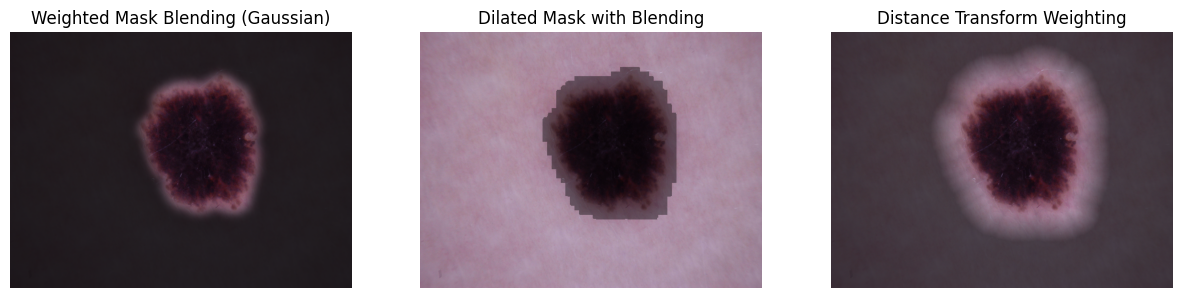

In [232]:
# Load the image and mask
image = cv2.imread("/Users/huytrq/Workspace/UdG/CAD/Data/Challenge1/train/nevus/nev00001.jpg")
mask = cv2.imread("/Users/huytrq/Workspace/UdG/CAD/Data/Challenge1/mask/train/nevus/nev00001.jpg", 0)  # Binary mask (0 for background, 255 for ROI)

# Normalize mask to binary (0 or 1)
mask = (mask > 0).astype(np.uint8)

# 1. Weighted Mask Blending with Gaussian Blur
blended_image1 = weighted_mask_blending(image, mask, blur_size=51)

# 2. Dilated Mask with Blending
blended_image2 = dilated_mask_with_blending(image, mask, dilation_size=20, blend_factor=0.5)

# 3. Distance Transform Weighting
blended_image3 = distance_transform_weighting(image, mask, max_distance=50)

# Display the results using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(blended_image1.astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[0].set_title("Weighted Mask Blending (Gaussian)")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(blended_image2.astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[1].set_title("Dilated Mask with Blending")
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(blended_image3.astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[2].set_title("Distance Transform Weighting")
axes[2].axis('off')

plt.show()
